##**Simple Chat with Streaming like ChatGpt**


In [13]:
!pip install langgraph langchain-core langchain-openai

In [14]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

In [25]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key, streaming=True)

In [47]:
from langgraph.graph import StateGraph, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

# ✅ Function node that streams tokens one-by-one
async def chat_node(state: MessagesState) -> dict:
    message = state["messages"][-1]
    print("User:", message.content)

    streamed_response = ""
    print("AI:", end=" ", flush=True)

    # Stream tokens one-by-one from the model
    async for chunk in model.astream([message]):
        token = chunk.content if chunk.content else ""
        print(token, end="", flush=True)
        streamed_response += token

    print()  # for newline after streaming is complete

    # Return updated message history with full streamed message
    return {"messages": state["messages"] + [AIMessage(content=streamed_response)]}

# ✅ Define the graph
builder = StateGraph(state_schema=MessagesState)
builder.add_node("chat_node", chat_node)
builder.set_entry_point("chat_node")
builder.set_finish_point("chat_node")

# ✅ Compile with memory
graph = builder.compile()
graph_with_memory = graph.with_config({"checkpoint": MemorySaver()})

# ✅ Run it
async def run_chat():
    inputs = {"messages": [HumanMessage(content="What's the capital of France?")]}
    await graph_with_memory.ainvoke(inputs)

await run_chat()


User: What's the capital of France?
AI: The capital of France is Paris.


####**Display graph**

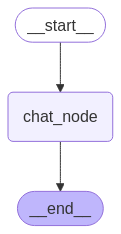

In [48]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)